In [1]:
!pip install gluonnlp pandas tqdm   
!pip install mxnet
!pip install sentencepiece==0.1.91
!pip install transformers==4.8.2
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sentencepiece-0.1.91.tar.gz (500 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.8.2-py3-none-any.whl (2.5 MB)
  Attem

In [2]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-z7kw6twg/kobert-tokenizer_d7241b5d44af4a95b256d19ccbdc538f
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-z7kw6twg/kobert-tokenizer_d7241b5d44af4a95b256d19ccbdc538f
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [3]:
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-e_fpvgmy
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-e_fpvgmy
  Resolved https://****@github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done
  Using cached transformers-4.8.1-py3-none-any.whl (2.5 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.8.2
    Uninstalling transformers-4.8.2:
      Successfully uninstalled transformers-4.8.2


In [4]:
from kobert_tokenizer import KoBERTTokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel, vocab = get_pytorch_kobert_model()

using cached model. /content/.cache/kobert_v1.zip
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook
import pandas as pd

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import BertModel

#GPU 사용 시
device = torch.device("cuda:0")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from mecab import MeCab
import warnings
warnings.filterwarnings("ignore")

In [8]:
data_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.03_미니프로젝트4차_실습자료/data/train.csv'
data = pd.read_csv(data_path)

In [9]:
label_dict = {
    '코드1': 0,
    '코드2': 0,
    '웹': 1,
    '이론': 2,
    '시스템 운영': 3,
    '원격': 4
}

data = data.replace(label_dict)
data.head()

,text,label
0,"self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, ...",0
1,현재 이미지를 여러개 업로드 하기 위해 자바스크립트로 동적으로 폼 여러개 생성하는데...,1
2,glob.glob(PATH) 를 사용할 때 질문입니다.\n\nPATH에 [ ] 가 ...,0
3,"tmpp = tmp.groupby(by = 'Addr1', as_index=Fals...",0
4,filename = TEST_IMAGE + str(round(frame_sec)) ...,0


In [10]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):
   
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))
         

    def __len__(self):
        return (len(self.labels))

In [11]:
# Setting parameters
max_len = 200
batch_size = 64
warmup_ratio = 0.1
num_epochs = 30
max_grad_norm = 1
log_interval = 200 # -> interval 줄이기 (42니까 20 정도로?)
learning_rate =  5e-5

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    data['text'], data['label'], test_size=0.2, 
    random_state=2023, stratify=data['label'])

In [13]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.1, 
    random_state=2023, stratify=y_train)

In [14]:
dataset_train = []
for sen, label in zip(x_train, y_train):
    dataset_train.append((sen, str(label)))
dataset_val = []
for sen, label in zip(x_val, y_val):
    dataset_val.append((sen, str(label)))
dataset_test = []
for sen, label in zip(x_test, y_test):
    dataset_test.append((sen, str(label)))

In [15]:
tk = tokenizer.tokenize
data_train = BERTDataset(dataset_train, 0, 1, tk, vocab, max_len, True, False)
data_val = BERTDataset(dataset_val, 0, 1, tk, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tk, vocab, max_len, True, False)

In [16]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
val_dataloader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=5,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        else:
            out = pooler
        return self.classifier(out)

In [18]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel).to(device)
 
#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 대표적인 loss func

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [19]:
# Early Stopping
best_loss = 10 ** 9 # 매우 큰 값으로 초기값 가정
patience_limit = 7 # 몇 번의 epoch까지 지켜볼지를 결정
patience_check = 0 # 현재 몇 epoch 연속으로 loss 개선이 안되는지를 기록

train_history=[]
val_history=[]
train_loss_history=[]
val_loss_history=[]
for e in range(num_epochs):
    train_acc, train_loss = 0.0, 0.0
    val_acc, val_loss = 0.0, 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
         
        #print(label.shape,out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        train_loss += loss.data.cpu().numpy()
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            # train_history.append(train_acc / (batch_id+1))
            # train_loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    print("epoch {} train loss {}".format(e+1, train_loss / (batch_id+1)))
    train_history.append(train_acc / (batch_id+1))
    train_loss_history.append(train_loss / (batch_id+1))
    
    model.eval()
    with torch.no_grad():
        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length= valid_length
            label = label.long().to(device)
            out = model(token_ids, valid_length, segment_ids)
            val_acc += calc_accuracy(out, label)
            val_loss += loss_fn(out, label).data.cpu().numpy()
    print("epoch {} val acc {}".format(e+1, val_acc / (batch_id+1)))
    print("epoch {} val loss {}".format(e+1, val_loss / (batch_id+1)))
    val_history.append(val_acc / (batch_id+1))
    val_loss_history.append(val_loss / (batch_id+1))

    ### early stopping 여부를 체크하는 부분 ###
    if val_loss > best_loss: # loss가 개선되지 않은 경우
        patience_check += 1

        if patience_check >= patience_limit: # early stopping 조건 만족 시 조기 종료
            break

    else: # loss가 개선된 경우
        best_loss = val_loss
        patience_check = 0

<ipython-input-19-5f2cae9d1ac8>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/42 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.5507900714874268 train acc 0.390625
epoch 1 train acc 0.4524501661129568
epoch 1 train loss 1.4253208325022744


<ipython-input-19-5f2cae9d1ac8>:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(val_dataloader)):


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 1 val acc 0.4899390243902439
epoch 1 val loss 1.2578014135360718


  0%|          | 0/42 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.2066795825958252 train acc 0.5
epoch 2 train acc 0.5854183970099668
epoch 2 train loss 1.0822737018267314


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 2 val acc 0.6734756097560975
epoch 2 val loss 0.9022736310958862


  0%|          | 0/42 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.8165217041969299 train acc 0.78125
epoch 3 train acc 0.7641542081949059
epoch 3 train loss 0.7170092967294511


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 3 val acc 0.7676067073170731
epoch 3 val loss 0.6718260645866394


  0%|          | 0/42 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.4395473003387451 train acc 0.890625
epoch 4 train acc 0.8828211517165007
epoch 4 train loss 0.3989602541994481


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 4 val acc 0.7832317073170731
epoch 4 val loss 0.6183483839035034


  0%|          | 0/42 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.20858058333396912 train acc 0.9375
epoch 5 train acc 0.9135087901439645
epoch 5 train loss 0.2913850192867574


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 5 val acc 0.7859756097560975
epoch 5 val loss 0.6936457753181458


  0%|          | 0/42 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.10504898428916931 train acc 0.984375
epoch 6 train acc 0.8971656976744187
epoch 6 train loss 0.32148217126017525


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 6 val acc 0.791234756097561
epoch 6 val loss 0.7164297103881836


  0%|          | 0/42 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.3926961123943329 train acc 0.84375
epoch 7 train acc 0.9503391472868217
epoch 7 train loss 0.16483154529262156


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 7 val acc 0.8082317073170732
epoch 7 val loss 0.7081119537353515


  0%|          | 0/42 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.15866418182849884 train acc 0.953125
epoch 8 train acc 0.9482886904761905
epoch 8 train loss 0.15975196366863592


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 8 val acc 0.8179878048780488
epoch 8 val loss 0.7097958505153656


  0%|          | 0/42 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.035959962755441666 train acc 0.984375
epoch 9 train acc 0.9549937707641197
epoch 9 train loss 0.14841084355222328


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 9 val acc 0.8277439024390244
epoch 9 val loss 0.7283316433429718


  0%|          | 0/42 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.02328033186495304 train acc 1.0
epoch 10 train acc 0.9722885520487264
epoch 10 train loss 0.10401747406770785


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 10 val acc 0.8291158536585366
epoch 10 val loss 0.755151554942131


  0%|          | 0/42 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 0.009866409003734589 train acc 1.0
epoch 11 train acc 0.9866071428571429
epoch 11 train loss 0.06651000445708632


  0%|          | 0/5 [00:00<?, ?it/s]

epoch 11 val acc 0.8336128048780488
epoch 11 val loss 0.8159896731376648


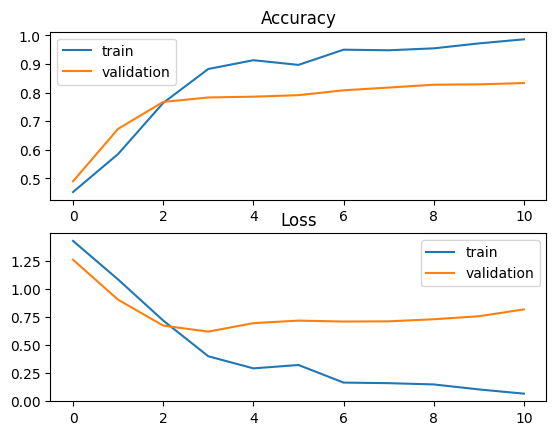

In [20]:
plt.subplot(2, 1, 1)
plt.title('Accuracy')
plt.plot(train_history, label='train')
plt.plot(val_history, label='validation')
plt.legend()

plt.subplot(2, 1, 2)
plt.title('Loss')
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='validation')
plt.legend()
plt.show()

In [21]:
model.eval()
test_acc = 0.0
y_pred = []
y_test = []
with torch.no_grad():
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
        y_test = np.hstack((y_test, label.cpu().numpy()))
        y_pred = np.hstack((y_pred, torch.max(out, 1)[1].cpu().numpy()))
print("test acc {}".format(test_acc / (batch_id+1)))

<ipython-input-21-9a414f948dde>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/12 [00:00<?, ?it/s]

test acc 0.8340871710526315


In [22]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))

[[271  13  23   9   1]
 [ 15 119   8   3   2]
 [ 33   2 107   4   0]
 [  6   1   3 102   0]
 [  0   1   0   0  19]]
              precision    recall  f1-score   support

         0.0       0.83      0.85      0.84       317
         1.0       0.88      0.81      0.84       147
         2.0       0.76      0.73      0.75       146
         3.0       0.86      0.91      0.89       112
         4.0       0.86      0.95      0.90        20

    accuracy                           0.83       742
   macro avg       0.84      0.85      0.84       742
weighted avg       0.83      0.83      0.83       742

0.8445178370444136


In [23]:
reverse_label = {}
for k, v in label_dict.items():
    reverse_label[v] = k

In [24]:
def predict(predict_sentence):
    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tk, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        logits=out[0]
        logits = logits.detach().cpu().numpy()
        pred = np.argmax(logits)
        print(f'>> 분류 결과 : {reverse_label[pred]}')

In [25]:
predict("tokenization은 어떤 역할을 하나요?")

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


>> 분류 결과 : 이론


In [26]:
predict("성능은 어떻게 올릴까요....")

>> 분류 결과 : 코드2


In [27]:
predict('for i in range(10)')

>> 분류 결과 : 코드2


In [28]:
predict('<a href="www.google.com"> Google </a>')

>> 분류 결과 : 웹


In [29]:
predict("성능은 어떻게 올릴까요....")

>> 분류 결과 : 코드2


In [30]:
predict("엔 그램 을 구현하는 방법이 뭔가요?")

>> 분류 결과 : 이론


In [31]:
predict("N-Gram 을 구현하는 방법이 뭔가요?")

>> 분류 결과 : 코드2


In [32]:
predict('N-Gram의 개념이 뭔가요?')

>> 분류 결과 : 이론


In [33]:
predict("출석 요청드립니다.")

>> 분류 결과 : 시스템 운영


In [35]:
save_path = '/content/drive/MyDrive/에이블스쿨/실습파일/2023.04.03_미니프로젝트4차_실습자료/save_model/'
torch.save(model, save_path + 'v4_kobert_200_0.8445_drop_x.pt')